# Module d'Identification de Pièces : Exploration et Justification
Ce notebook décompose l'étape d'identification des pièces d'Euro. Une fois les pièces détectées (cercles), nous devons déterminer leur métal (Cuivre, Or, Bimétallique) puis leur valeur exacte (1c à 2€).

**Étapes couvertes ici :**
1. L'importance des espaces colorimétriques (HSV et LAB) face au classique BGR.
2. Le calcul du "Bimetallic Score" (détection du contraste cœur/anneau).
3. L'étalonnage de la taille (Relative Sizing) pour trouver la valeur exacte.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fonction générique pour comparer plusieurs images côte à côte
def plot_comparison(images, titles, figsize=(18, 5)):
    """Affiche une liste d'images avec leurs titres correspondants."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    
    if n == 1: 
        axes = [axes]
        
    for ax, img, title in zip(axes, images, titles):
        # Si l'image a 3 canaux, on la convertit de BGR (OpenCV) à RGB (Matplotlib)
        if len(img.shape) == 3:
            img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
        else:
            # Sinon, c'est une image 1 canal (niveaux de gris ou masque)
            ax.imshow(img, cmap='gray')
            
        ax.set_title(title, fontsize=14)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

In [18]:
# Définition des constantes de la réalité physique
COIN_SPECS = {
    '1c':    {'diameter_mm': 16.25, 'color_group': 'copper',     'value': 0.01},
    '2c':    {'diameter_mm': 18.75, 'color_group': 'copper',     'value': 0.02},
    '5c':    {'diameter_mm': 21.25, 'color_group': 'copper',     'value': 0.05},
    '10c':   {'diameter_mm': 19.75, 'color_group': 'gold',       'value': 0.10},
    '20c':   {'diameter_mm': 22.25, 'color_group': 'gold',       'value': 0.20},
    '50c':   {'diameter_mm': 24.25, 'color_group': 'gold',       'value': 0.50},
    '1euro': {'diameter_mm': 23.25, 'color_group': 'bimetallic', 'value': 1.00},
    '2euro': {'diameter_mm': 25.75, 'color_group': 'bimetallic', 'value': 2.00},
}

# Helper lists to quickly determine which values belong to which color family
COPPER_DENOMS  = ['1c', '2c', '5c']
GOLD_DENOMS    = ['10c', '20c', '50c']
BIMETAL_DENOMS = ['1euro', '2euro']

# In the photo, we rely on the fact that the biggest copper coin must be a 5c coin, etc.
LARGEST_BY_COLOR = {'copper': '5c', 'gold': '50c', 'bimetallic': '2euro'}

### 1. Extraction des caractéristiques : Pourquoi LAB et HSV ?


[Image of CIELAB color space]

L'espace RGB (ou BGR dans OpenCV) est très sensible aux variations de lumière. Si une pièce de cuivre est dans l'ombre, ses valeurs R, G et B vont toutes s'effondrer.
- L'espace **LAB** sépare complètement la luminosité (`L`) des couleurs réelles (`a*` pour l'axe Vert-Rouge, `b*` pour l'axe Bleu-Jaune). C'est parfait pour trouver le Cuivre (très rouge, donc fort `a*`).
- L'espace **HSV** (Teinte, Saturation, Valeur) nous permet d'étudier la *variance de saturation*. Une pièce purement en cuivre est uniforme. Une pièce bimétallique a une saturation qui varie fortement entre le centre et le bord.

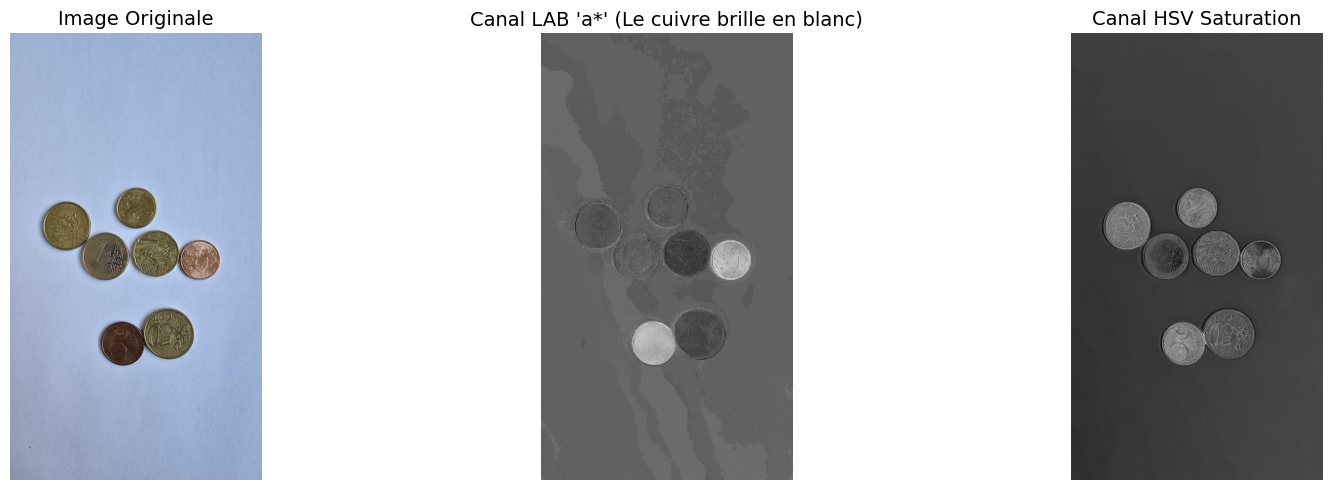

In [6]:
# REMPLACE par une image contenant idéalement une pièce de chaque type (Cuivre, Or, Bimétallique)
img_id_path = './data/gp4/6.jpg' # Ajuste le chemin selon ton dossier !
img_id = cv2.imread(img_id_path)

if img_id is not None:
    # On redimensionne un peu pour que ça s'affiche bien
    h, w = img_id.shape[:2]
    img_id = cv2.resize(img_id, (800, int(h * (800/w))), interpolation=cv2.INTER_AREA)
    
    # Conversions
    hsv = cv2.cvtColor(img_id, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img_id, cv2.COLOR_BGR2Lab)
    
    # Extraction des canaux spécifiques pour la démo
    # Canal a* du LAB (Axe Vert --> Rouge)
    lab_a = lab[:, :, 1] 
    
    # Canal Saturation du HSV
    hsv_s = hsv[:, :, 1]
    
    plot_comparison(
        [img_id, lab_a, hsv_s], 
        ['Image Originale', "Canal LAB 'a*' (Le cuivre brille en blanc)", 'Canal HSV Saturation']
    )
else:
    print(f"Erreur: Impossible de charger {img_id_path}")

### 2. Le "Bimetallic Score" (Contraste Cœur vs Anneau)
Comment différencier une grosse pièce en or (50c) d'une pièce bimétallique (2€) ?
Notre méthode `_enh_bimetallic` découpe virtuellement la pièce en deux zones (un cœur central et un anneau extérieur) et calcule la "distance" colorimétrique entre les deux.

Comme la bordure entre les deux métaux change selon la perspective, l'algorithme teste **5 ratios différents** et garde le contraste le plus élevé.

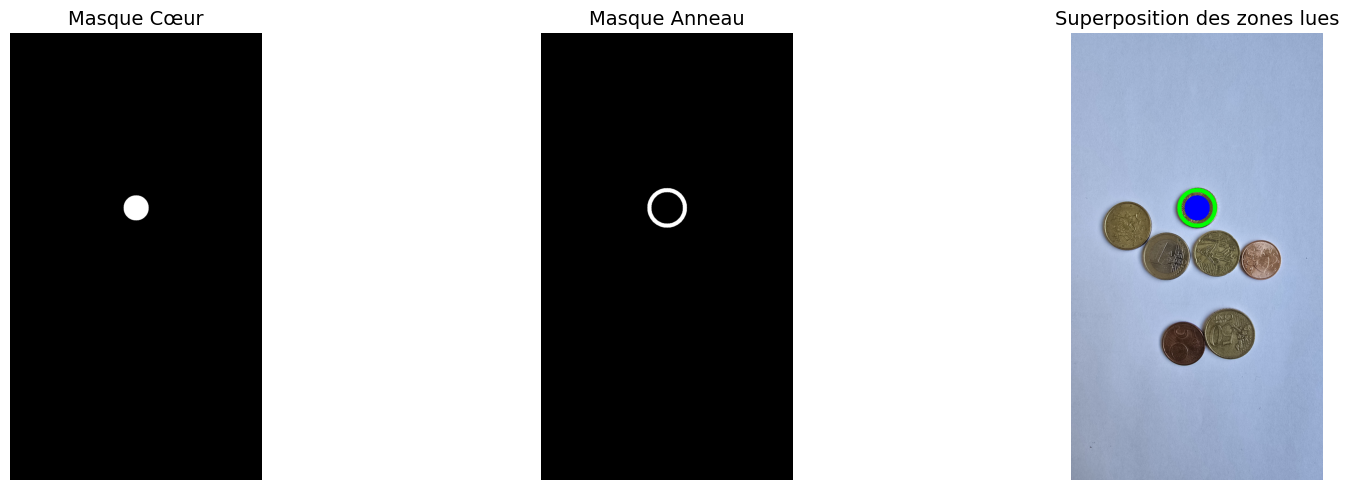

Couleur moyenne du Cœur (LAB) : [96, 128, 149]
Couleur moyenne de l'Anneau (LAB) : [101, 128, 148]
Distance colorimétrique (Bimetallic Score) calculée : 5.14
Si ce score est > 12, le code la classera comme Bimétallique (1€ ou 2€) !


In [25]:
# Simulation sur une zone précise de l'image. 
# CHERCHE LES COORDONNÉES D'UNE PIÈCE DE 1€ OU 2€ DANS TON IMAGE ET REMPLACE LES VALEURS x, y, r
x_sim, y_sim, r_sim = 400, 555, 80 # Obtient un score de 67.78 (pièce de 10c)
# x_sim, y_sim, r_sim = 400, 300, 50 # Obtient un score de 1.08 (hors des pièces, partie blanche du fond)

# On va générer les masques pour un des ratios testés dans le code (ex: ratio = 0.58)
ratio = 0.58
ir = max(int(r_sim * (ratio - 0.07)), 2) # Rayon du coeur (Inner Radius)
oi = int(r_sim * (ratio + 0.05))         # Début de l'anneau (Outer Inner)
oo = int(r_sim * min(ratio + 0.22, 0.88))# Fin de l'anneau (Outer Outer)

# Masque Cœur
mask_core = np.zeros(lab.shape[:2], dtype=np.uint8)
cv2.circle(mask_core, (x_sim, y_sim), ir, 255, -1)

# Masque Anneau
mask_ring = np.zeros(lab.shape[:2], dtype=np.uint8)
cv2.circle(mask_ring, (x_sim, y_sim), oo, 255, -1)
cv2.circle(mask_ring, (x_sim, y_sim), oi, 0, -1) # On évide le centre

# On superpose en couleur pour bien voir sur l'image
img_demo_score = img_id.copy()
# On teinte le coeur en bleu, l'anneau en vert
img_demo_score[mask_core == 255] = [255, 0, 0] 
img_demo_score[mask_ring == 255] = [0, 255, 0]

plot_comparison(
    [mask_core, mask_ring, img_demo_score], 
    ['Masque Cœur', 'Masque Anneau', 'Superposition des zones lues']
)

# Calcul simulé
mean_core = cv2.mean(lab, mask=mask_core)[:3]
mean_ring = cv2.mean(lab, mask=mask_ring)[:3]
dist_color = float(np.linalg.norm(np.array(mean_core) - np.array(mean_ring)))

print(f"Couleur moyenne du Cœur (LAB) : {[int(c) for c in mean_core]}")
print(f"Couleur moyenne de l'Anneau (LAB) : {[int(c) for c in mean_ring]}")
print(f"Distance colorimétrique (Bimetallic Score) calculée : {dist_color:.2f}")
print("Si ce score est > 12, le code la classera comme Bimétallique (1€ ou 2€) !")

### 3. Étalonnage et Tailles Relatives (Relative Sizing)
[Image of Euro coin size comparison]
Pour deviner la valeur exacte d'une pièce, nous devons connaître son diamètre en millimètres. Mais dans une photo, nous n'avons que des pixels. 
**Comment trouver l'échelle (le ratio pixels/mm) sans objet de référence ?**

L'astuce consiste à utiliser les propriétés physiques inaltérables de la monnaie Euro :
1. On cherche la **plus grande pièce** de l'image (en pixels).
2. On regarde sa **couleur**.
3. On sait que la plus grande pièce Cuivre est *toujours* la 5c. La plus grande pièce Or est *toujours* la 50c. La plus grande Bimétallique est *toujours* la 2€.
4. On utilise cette pièce "Ancre" pour calculer notre ratio, et on l'applique à toutes les autres.

In [23]:
# Données simulées (Rayons en pixels et groupes de couleurs identifiés plus tôt)
coins_simulated = [
    {'id': 1, 'r': 85, 'color_group': 'bimetallic'}, # La plus grosse pièce
    {'id': 2, 'r': 53, 'color_group': 'copper'},     # Une petite pièce
    {'id': 3, 'r': 70, 'color_group': 'copper'},     # Une pièce moyenne
    {'id': 4, 'r': 65, 'color_group': 'gold'}        # Une autre pièce moyenne
]

# --- ÉTAPE 1 : ÉTALONNAGE ---
# Trouver l'Ancre (La plus grande pièce en pixels)
max_r = max(c['r'] for c in coins_simulated)
largest = next(c for c in coins_simulated if c['r'] == max_r)

# Identifier sa valeur réelle théorique selon sa couleur
ref_coin_name = LARGEST_BY_COLOR.get(largest['color_group'], '50c')
ref_diameter_mm = COIN_SPECS[ref_coin_name]['diameter_mm']

# Calculer le ratio magique (Pixels par Millimètre)
px_mm = (max_r * 2) / ref_diameter_mm

print(f"--- RÉSULTATS DE L'ÉTALONNAGE ---")
print(f"Pièce Ancre (Plus grande) : Rayon {max_r}px, Couleur '{largest['color_group']}'")
print(f"   => Identifiée comme : {ref_coin_name} ({ref_diameter_mm} mm)")
print(f"   => Ratio d'échelle calculé : 1 mm = {px_mm:.2f} pixels\n")


# --- ÉTAPE 2 : ASSIGNATION ---
final_results = [] # On va stocker les résultats ici pour les dessiner après

print(f"--- DÉTAIL DES CALCULS ---")
for c in coins_simulated:
    # 1. Conversion Pixels -> Millimètres estimés
    dia_mm_est = (c['r'] * 2) / px_mm
    
    # 2. Choix de la liste de candidats selon la couleur
    cands = (COPPER_DENOMS if c['color_group'] == 'copper'
             else GOLD_DENOMS if c['color_group'] == 'gold'
             else BIMETAL_DENOMS)
    
    # 3. Trouver la taille officielle la plus proche
    best_match = min(cands, key=lambda d: abs(COIN_SPECS[d]['diameter_mm'] - dia_mm_est))
    true_dia = COIN_SPECS[best_match]['diameter_mm']
    
    print(f"Pièce {c['id']} ({c['color_group']}) : Diamètre {c['r']*2}px")
    print(f"   -> Estimation physique : {dia_mm_est:.2f} mm")
    print(f"   -> Valeur officielle la plus proche : {best_match} ({true_dia} mm)\n")
    
    # On sauvegarde le résultat complet
    res = c.copy()
    res.update({'denomination': best_match, 'est_mm': dia_mm_est})
    final_results.append(res)

--- RÉSULTATS DE L'ÉTALONNAGE ---
Pièce Ancre (Plus grande) : Rayon 85px, Couleur 'bimetallic'
   => Identifiée comme : 2euro (25.75 mm)
   => Ratio d'échelle calculé : 1 mm = 6.60 pixels

--- DÉTAIL DES CALCULS ---
Pièce 1 (bimetallic) : Diamètre 170px
   -> Estimation physique : 25.75 mm
   -> Valeur officielle la plus proche : 2euro (25.75 mm)

Pièce 2 (copper) : Diamètre 106px
   -> Estimation physique : 16.06 mm
   -> Valeur officielle la plus proche : 1c (16.25 mm)

Pièce 3 (copper) : Diamètre 140px
   -> Estimation physique : 21.21 mm
   -> Valeur officielle la plus proche : 5c (21.25 mm)

Pièce 4 (gold) : Diamètre 130px
   -> Estimation physique : 19.69 mm
   -> Valeur officielle la plus proche : 10c (19.75 mm)



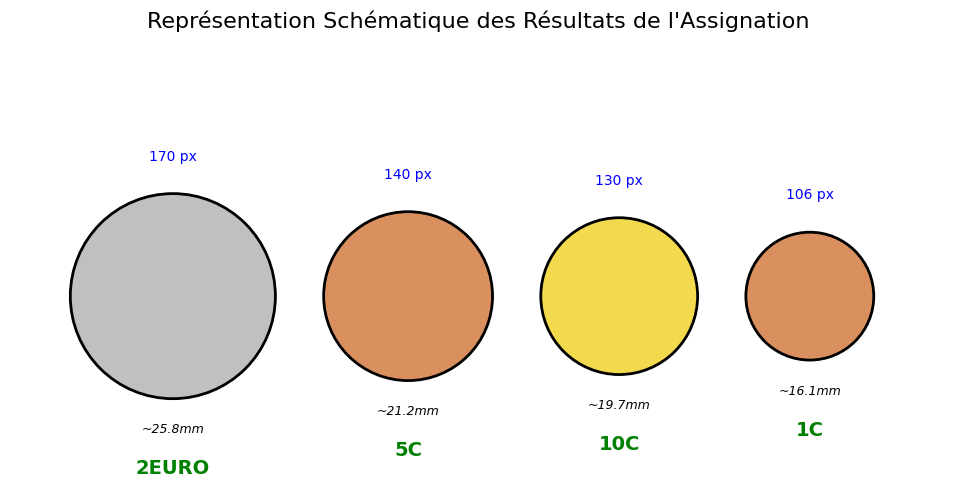

In [24]:
import matplotlib.patches as patches

# Création de la figure
fig, ax = plt.subplots(figsize=(14, 5))

# Couleurs schématiques pour le dessin
color_map = {
    'copper': '#d98f5e',    # Cuivre/Orange
    'gold': '#f2d94e',      # Or/Jaune
    'bimetallic': '#c0c0c0' # Argent/Gris (simplifié)
}

# Position de départ sur l'axe X
current_x = 50
center_y = 150

# On trie les résultats par taille pour faire joli sur le dessin
sorted_results = sorted(final_results, key=lambda x: x['r'], reverse=True)

for coin in sorted_results:
    r_px = coin['r']
    denom = coin['denomination']
    group = coin['color_group']
    est_mm = coin['est_mm']
    
    # 1. Dessiner le cercle proportionnel aux pixels
    # Le centre du cercle est décalé de son rayon pour qu'ils soient alignés à gauche
    circle = patches.Circle((current_x + r_px, center_y), r_px, 
                            facecolor=color_map[group], edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    
    # 2. Ajouter les textes
    # Diamètre en pixels au-dessus
    ax.text(current_x + r_px, center_y + r_px + 25, f"{r_px*2} px", 
            ha='center', va='bottom', fontsize=10, color='blue')
    
    # Estimation mm en dessous
    ax.text(current_x + r_px, center_y - r_px - 20, f"~{est_mm:.1f}mm", 
            ha='center', va='top', fontsize=9, fontstyle='italic')
    
    # RÉSULTAT FINAL en gros et gras
    ax.text(current_x + r_px, center_y - r_px - 50, denom.upper(), 
            ha='center', va='top', fontsize=14, fontweight='bold', color='green')

    # On décale la position X pour la prochaine pièce, en laissant un espace de 40px
    current_x += (r_px * 2) + 40

# Réglages esthétiques du graphique
ax.set_xlim(0, current_x + 20)
ax.set_ylim(0, 350)
ax.set_aspect('equal') # Important pour que les cercles soient ronds !
ax.axis('off') # On cache les axes gradués
ax.set_title("Représentation Schématique des Résultats de l'Assignation", fontsize=16, pad=20)

plt.tight_layout()
plt.show()